# The Simplest Graph


![Screenshot 2024-08-20 at 3.11.22 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dba5f465f6e9a2482ad935_simple-graph1.png)

## State

First, define the [State](https://langchain-ai.github.io/langgraph/concepts/low_level/#state) of the graph. 

The State schema serves as the input schema for all Nodes and Edges in the graph.

Let's use the `TypedDict` class from python's `typing` module as our schema, which provides type hints for the keys.

In [1]:
from typing_extensions import TypedDict

class State(TypedDict):
    graph_state: str

## Nodes

[Nodes](https://langchain-ai.github.io/langgraph/concepts/low_level/#nodes) are just python functions.

The first positional argument is the state, as defined above.

Because the state is a `TypedDict` with schema as defined above, each node can access the key, `graph_state`, with `state['graph_state']`.

Each node returns a new value of the state key `graph_state`.
  
By default, the new value returned by each node [will override](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) the prior state value.

In [31]:
def node_1(state):
    print("---Node 1---")
    return {"graph_state": state['graph_state'] +" Я мав"}

def node_2(state):
    print("---Node 2---")
    return {"graph_state": state['graph_state'] +"па рижа!"}

def node_3(state):
    print("---Node 3---")
    return {"graph_state": state['graph_state'] +" Парижа!"}

## Edges

[Edges](https://langchain-ai.github.io/langgraph/concepts/low_level/#edges) connect the nodes.

Normal Edges are used if you want to *always* go from, for example, `node_1` to `node_2`.

[Conditional Edges](https://langchain-ai.github.io/langgraph/concepts/low_level/#conditional-edges) are used if you want to *optionally* route between nodes.
 
Conditional edges are implemented as functions that return the next node to visit based upon some logic.

In [10]:
import random
from typing import Literal

def decide_mood(state) -> Literal["node_2", "node_3"]:
    
    # Often, we will use state to decide on the next node to visit
    user_input = state['graph_state'] 
    
    # Here, let's just do a 50 / 50 split between nodes 2, 3
    if random.random() < 0.5:

        # 50% of the time, we return Node 2
        return "node_2"
    
    # 50% of the time, we return Node 3
    return "node_3"

## Graph Construction

Now, we build the graph from our [components](
https://langchain-ai.github.io/langgraph/concepts/low_level/) defined above.

The [StateGraph class](https://langchain-ai.github.io/langgraph/concepts/low_level/#stategraph) is the graph class that we can use.
 
First, we initialize a StateGraph with the `State` class we defined above.
 
Then, we add our nodes and edges.

We use the [`START` Node, a special node](https://langchain-ai.github.io/langgraph/concepts/low_level/#start-node) that sends user input to the graph, to indicate where to start our graph.
 
The [`END` Node](https://langchain-ai.github.io/langgraph/concepts/low_level/#end-node) is a special node that represents a terminal node. 

Finally, we [compile our graph](https://langchain-ai.github.io/langgraph/concepts/low_level/#compiling-your-graph) to perform a few basic checks on the graph structure. 

We can visualize the graph as a [Mermaid diagram](https://github.com/mermaid-js/mermaid).

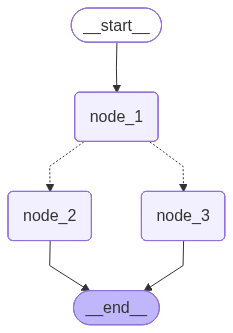

In [32]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

## Graph Invocation

The compiled graph implements the [runnable](https://python.langchain.com/docs/concepts/runnables/) protocol.

This provides a standard way to execute LangChain components. 
 
`invoke` is one of the standard methods in this interface.


When `invoke` is called, the graph starts execution from the `START` node.

It progresses through the defined nodes (`node_1`, `node_2`, `node_3`) in order.

The conditional edge will traverse from node `1` to node `2` or `3` using a 50/50 decision rule. 

Each node function receives the current state and returns a new value, which overrides the graph state.

The execution continues until it reaches the `END` node.

In [75]:
graph.invoke({"graph_state" : "Привіт"})

---Node 1---
---Node 3---


{'graph_state': 'Привіт Я мав Парижа!'}

`invoke` runs the entire graph synchronously.

This waits for each step to complete before moving to the next.

It returns the final state of the graph after all nodes have executed.

In this case, it returns the state after `node_3` has completed: 

```
{'graph_state': 'Привіт Я мав Парижа!'}
```

# First agent

In [1]:
import os
from dotenv import load_dotenv

from typing import TypedDict, List, Dict, Any, Optional
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
import requests
from striprtf.striprtf import rtf_to_text

load_dotenv()
api_key = os.getenv("OPENAI_API_KEY")
model = ChatOpenAI(model="gpt-4o", temperature=0)

In [2]:
url = "http://od.reyestr.court.gov.ua/files/61/520ce2d5f53b2a22eafd30fca9c17d43.rtf"

In [3]:
class AgentState(TypedDict):
    url: str

In [22]:
def extract_rtf_text(url: str) -> str:
    """
    Extract text from URL in RTF format.

    Args:
        url (str): The URL of the RTF document.

    Returns:
        str: The extracted plain text from the RTF document.
    """
    response = requests.get(url)
    response.raise_for_status()

    rtf_content = response.content.decode("utf-8", errors="ignore")

    text = rtf_to_text(rtf_content)
    return text

# def summarize_text(text: str) -> str:
#     """
#     Summarizes the given text using the LLM.
    
#     Args:
#         text (str): The text to summarize.

#     Returns:
#         str: The summary of the text.
#     """

#     prompt = f"Summarize the following text:\n\n{text}"
#     response = model.invoke([HumanMessage(content=prompt)])
#     return response.content


model = ChatOpenAI(model="gpt-4o", temperature=0)
tools = [extract_rtf_text]#, summarize_text]
llm_with_tools = model.bind_tools(tools, parallel_tool_calls=False)

In [20]:
x = llm_with_tools.invoke([HumanMessage(content=f"Extract text from URL in RTF format {url}")])

In [25]:
x = llm_with_tools.invoke(f"Extract text from URL in RTF format {url}")

In [26]:
x

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_AWWEo4xGC1Xp3Fv5XJGj51pW', 'function': {'arguments': '{"url":"http://od.reyestr.court.gov.ua/files/61/520ce2d5f53b2a22eafd30fca9c17d43.rtf"}', 'name': 'extract_rtf_text'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 52, 'prompt_tokens': 102, 'total_tokens': 154, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_65564d8ba5', 'id': 'chatcmpl-CTBaAUd5nZP4bUvksECmvPyvyyQWC', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--688040ed-70dc-40e3-9824-2bf33fd200e7-0', tool_calls=[{'name': 'extract_rtf_text', 'args': {'url': 'http://od.reyestr.court.gov.ua/files/61/520ce2d5f53b2a22eafd30fca9c17d43.rtf'}, 'id': 'call_AWWEo4xGC1X

In [10]:
def tool_calling_llm(state: AgentState):
    return {"messages": [llm_with_tools.invoke(f'Extract text from URL in RTF format  {state["url"]}')]}

In [11]:
builder = StateGraph(AgentState)

builder.add_node("tool_calling_llm", tool_calling_llm)
# builder.add_node("summarize_text", summarize_text)

builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
# builder.add_edge("extract_rtf_text", "summarize_text")
# builder.add_edge("summarize_text", END)

first_agent = builder.compile()

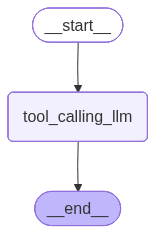

In [12]:
from IPython.display import Image, display

display(Image(first_agent.get_graph(xray=True).draw_mermaid_png()))

In [13]:
first_agent.invoke({"url": HumanMessage(content=url)})

{'url': HumanMessage(content='http://od.reyestr.court.gov.ua/files/61/520ce2d5f53b2a22eafd30fca9c17d43.rtf', additional_kwargs={}, response_metadata={})}